In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit, prange
from BT_RD.my_functions import Update_Adjacency_Matrix, RK4

In [2]:
#################### PROBABILITY_DISTRIBUTION_OPINION ###############
# Calculates the Probabilities of Agent numb_node connecting with others based
# on their opinion distance

@njit(parallel=True)
def Probability_Distribution_Opinion(G, numb_node, T, beta, Phi):
    N = len(G)
    prob = np.zeros(N)

    distance = np.zeros(N)

    # Calculate Norm
    norm = 0
    for i in prange (N):
        if i != numb_node: 
            # numb_node is the number of the selected node
            for u in range (T):
                for v in range (T):
                    distance[i] += (G[i][u] - G[numb_node][u]) * (G[i][v] - G[numb_node][v]) * Phi[u][v]
            norm += np.sqrt(distance[i])**(-beta)
        

    # Calculate Probability of contact
    for i in prange (N): 
        if i != numb_node:
            prob[i] = (np.sqrt(distance[i])**(-beta) / norm)
    return prob
    
#################### ODEs ###########################################
# Numerical integration of differential equation

@njit(parallel = True)
def ODEs(N, T, A, K, alpha, Phi, current_opinions, opinions_step):
    # Determine social influence to return the differential. current_opinions and opinions_step
    # are arrays of the form [..., [agent_i_op1, agent_i_op2], [agent_i+1_op1, agent_i+1_op2], ...]
    influence = np.zeros((N,T))
    count = np.zeros((N,T))
    for i in prange (N):
        for o in range (T):
            # Go through connected agents of i
            while A[i][int(count[i][o])] != N+1:
                influence[i][o] += np.tanh(alpha * np.dot(Phi, current_opinions[A[i][int(count[i][o])]])[o])
                count[i][o] += 1

    #return differential
    dxdt = -opinions_step + K * influence
    return dxdt

#################### RK4 #############################################
# Perform 4th order Runge-Kutta on the differential equation of the model

@njit(parallel = True)
def RK4(G, T, A, K, alpha, Phi, dt):
    N = len(G)
    # Save current opinions
    current_opinions = np.zeros((N,T))
    for i in prange (N):
        for j in range (T):
            current_opinions[i][j] += G[i][j]

    # Calculate ks
    k1 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions)
    k2 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k1)
    k3 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + 0.5 * k2)
    k4 = dt * ODEs(N, T, A, K, alpha, Phi, current_opinions, current_opinions + k3)

    # Calculate total change and update opinions
    k = 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    current_opinions += k
    for i in range (N):
        for j in range (T):
            G[i][j] = current_opinions[i][j]

#################### UPDATE_ADJACENCY_MATRIX #########################
# Updates Adjacency Matrix. If a connection is established multiple times in the
# Network iterations, the connection is still only counted as one connection,
# so that it isn´t weighted.

@njit(parallel = True)
def Update_Adjacency_Matrix(Adj, A, N):
    count = np.zeros(N)
    for i in range (N):
        # Again N+1 is the breaking value
        while A[i][int(count[i])] != N+1:
            con = A[i][int(count[i])]
            Adj[i][con] = 1
            Adj[con][i] = 1
            count[i] += 1

##################### CONNECT #######################################
# Form adjacency array for timestep. Array entry i contains all adjacent nodes of i. Other values are initialized with N+1
# as a breaking value so ODEs doesn´t go through the whole array

def Connect(N, m, G, G_num, T, beta, Phi):
    A = np.full((N,N), N+1)
    # Create counting array to place adjacent nodes correctly in array
    count_arr = np.zeros(N, dtype=int)

    act_count = 0

    for i in range (N):
        # Go through nodes and possibly activate them
        rand = np.random.uniform(0,1)
        if rand <= G[i][T]:
            act_count += 1
            # Pick m other nodes randomly. No exception of i needed, since
            # P_D_O excludes i already
            prob = Probability_Distribution_Opinion(G, i, T, beta, Phi)
            picks = np.random.choice(G_num, m, replace=False, p=prob)
            #Update adjacency list: append nodes j to i´s place and vice versa
            for j in picks:
                A[i][count_arr[i]] = j
                A[j][count_arr[j]] = i
                count_arr[i] += 1
                count_arr[j] += 1

    return A, act_count

##################### ASSING_ACTIVITY ###############################
# Assigns activities following a powerlaw distribution

@njit
def Assign_Activity(eps1, eps2, gamma):
    rand = np.random.uniform(0, 1)
    power_rand = (eps1**(1-gamma) + (eps2**(1-gamma) - eps1**(1-gamma)) * rand)**(1/(1-gamma))
    return power_rand

##################### SAVE ###########################################
# Save results

def Save(save, Adj, N, T, filename, path, save_Adj = False):
    # Create Dataframe and convert it to .csv
    df = pd.DataFrame(save)
    df.to_csv(f"{path}\{filename}.csv", index = False, header = False)

    # Save Adjacency Matrix
    if save_Adj == True:
        pd.DataFrame(Adj).to_csv(f"{path}\{filename}_mat.csv", index = False, header = False)
    




##################### OPINION_DYNAMICS ################################

def Opinion_Dynamics(N, T, m, K, alpha, beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, dt, filename, path, ret_means=False):
    # Parameters N to eps1 are the same as in the paper introducing the model. Eps2 is the upper bound for activity,
    # runtime_net is the number of times a new AD-network is formed, runtime_op is the number of opinion-iterations
    # performed on that network. Default is runtime_op = 1. dt is the integration time-step and filename is a string
    # containing the name of the file in which the opinion dynamcis of the agents are saved (filename.csv).

    # Create array to save opinions of all agents after every network-iteration
    #save = np.zeros((runtime_net * T + 1, N))
    # ALTERNATIVE: only save beginning and end opinions for saving a lot of space on your hard-drive.
    save = np.zeros((5, N))

    # Create Array that contains node's activities and opinions
    G = np.zeros((N,T+1))
    # Give each array entry (node) a number, save in array G_num
    G_num = np.arange(0,N)
    # To later retrieve the integrated network over the last 70 iterations (As in the paper) create
    # an adjacency matrix
    Adj = np.zeros((N,N))
    # save # of active nodes per iteration
    acts = np.zeros(runtime_net)

    # Initialize Activity and Opinions of Nodes
    for i in range (N):
        G[i][T] = Assign_Activity(eps1, eps2, gamma)
        for j in range (T):
            G[i][j] = np.random.normal(0, np.sqrt(2.5))
    # Save activities of agents in first row of save

    # Initialize arrays for retrieving the mean opinions of agents over 10 iterations each and for calculating the differences
    # between these means. This is used for stability analysis.
    ops = np.zeros((runtime_net+1, N, T))
    diffs = np.zeros((int(runtime_net/10)-1, N))
    means = np.zeros((int(runtime_net/10), N, T))

    for i in range (N):
        save[0][i] += G[i][T]

    # Save first two opinions
    save[1] = G[:,0]
    save[2] = G[:,1]

    # Perform Iterations until runtime_net is reached
    iteration_net = 0

    ops[iteration_net] = G[:,:T] 

    while iteration_net < runtime_net:

        # Form connections between Agents
        A, acts[iteration_net] = Connect(N, m, G, G_num, T, beta, Phi)
        
        # Calculate the influence of the nodes on eachother
        iteration_op = 0
        while iteration_op < runtime_op:
            # Update opinions via Runge-Kutta 4
            RK4(G, T, A, K, alpha, Phi, dt)
            # increase iteration
            iteration_op += 1
        
        # Only do this if you want each opinion saved
        # Save opinions of agents
        # for i in range (N):
        #     for j in range(T):
        #         first row of save contains activities. After that for each iteration there´s a row for each iteration,
        #         i.e. for two opinions two rows per iteration. 
        #         save[(T*iteration_net)+j+1][i] += G[i][j]
        
        # Update adjacency matrix if last 70 iterations are reached
        if iteration_net >= runtime_net - 71:
            Update_Adjacency_Matrix(Adj, A, N)

        # Print progress bar
        if iteration_net % (int(runtime_net/100)) == 0:
            percent = int(100 * iteration_net/runtime_net)
            #print(percent)
            left = 40 * percent // 100
            right = 40 - left
    
            tags = "#" * left
            spaces = " " * right
            percents = f"{percent:.0f}%"
    
            print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)

        iteration_net += 1

        # Calculate mean difference of opinions
        ops[iteration_net] = G[:,:T]
        
        if iteration_net % 10 == 0:
            # Calculate mean of opinion over last 10 iterations
            for i in range(N):
                for j in range(T):
                    for k in range(10):
                        means[int(iteration_net/10)-1][i][j] += ops[iteration_net-1-k][i][j]
            means[int(iteration_net/10)-1] = means[int(iteration_net/10)-1] / 10

            # Calculate differences between means
            if iteration_net > 10:
                for i in range(N):
                    for j in range(T):
                        diffs[int(iteration_net/10)-2][i] += (means[int(iteration_net/10)-1][i][j] - means[int(iteration_net/10)-2][i][j])**2
                diffs[int(iteration_net/10)-2] = np.sqrt(diffs[int(iteration_net/10)-2])


    # Save last opinions
    save[3] = G[:,0]
    save[4] = G[:,1]

    Save(save, Adj, N, T, filename, path)

    # Calculate mean number of agents being active per iteration
    act_med = 0
    for i in range (len(acts)):
        act_med += acts[i]
    act_med = act_med/runtime_net

    if ret_means == True:
        df = pd.DataFrame(diffs)
        df.to_csv(f"{path}\{filename}_means.csv", index = False, header = False)

    # Print last part of progress bar
    percents = f"{100:.0f}%"
    tags = "#" * 40
    print("\r[", tags, "]", percents, "\n", sep="", end="", flush=True)

    return act_med
        
            



In [18]:
N = 2500 # 1000 nodes should be the minimum, below initial fluctuations take over and polarization becomes instable
T = 2
m = 10 # np.floor(N+50/100)
K = 3
alpha = 2.5
#alpha = 1.0
beta = 5.0
gamma = 2.1
cosd = 0.0
Phi=np.array([[1.0,cosd],[cosd,1.0]])
#cosd = np.arange(-0.25,1.05,0.05)
eps1 = 0.01
eps2 = 1.0
runtime_net = 10**3 # Stability is reached from about 500 iterations
runtime_op = 1
step = 0.01
print("m: ", m)
#print("Phi: ", Phi[0][0], Phi[0][1], Phi[1][0], Phi[1][1])
# File Names should be a 2-dim array with the first dimension being for each wanted value of a parameter
# and the second dimension full of array names for the multiple simulations.
path = "D:/Daten mit Änderungen/Physik/Bachelorarbeit/Generated_Data/Original"

m:  10


In [6]:
# Run phase-space simulations

File_Names = []
for i in range (len(alpha)):
    File_Names2 = []
    for j in range (len(cosd)):
        File_Names3 = []
        for k in range (1):
            File_Names3.append(f'a{alpha[i]:.1f}_b{beta}_cosd{cosd[j]:.2f}_{k+2}')
        File_Names2.append(File_Names3)
    File_Names.append( File_Names2 )

#print(File_Names)

for i in range (len(alpha)):
    for j in range (len(cosd)):
        for k in range(1):
            print(f"\rsimulation {i*len(File_Names[0]) + j + 1} of {len(File_Names) * len(File_Names[0])}", flush=True)
            Phi = np.array( [[1.0, cosd[j]], [cosd[j], 1.0]] )
            Opinion_Dynamics(N, T, m, K, alpha[i], beta, gamma, Phi, eps1, eps2, runtime_net, runtime_op, step, File_Names[i][j][k], path)

simulation 1 of 364
[########################################]100%
simulation 2 of 364
[########################################]100%
simulation 3 of 364
[########################################]100%
simulation 4 of 364
[########################################]100%
simulation 5 of 364
[########################################]100%
simulation 6 of 364
[########################################]100%
simulation 7 of 364
[########################################]100%
simulation 8 of 364
[########################################]100%
simulation 9 of 364
[########################################]100%
simulation 10 of 364
[########################################]100%
simulation 11 of 364
[########################################]100%
simulation 12 of 364
[########################################]100%
simulation 13 of 364
[########################################]100%
simulation 14 of 364
[########################################]100%
simulation 15 of 364
[###################################

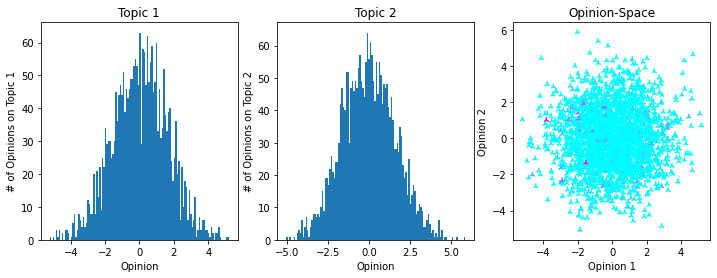

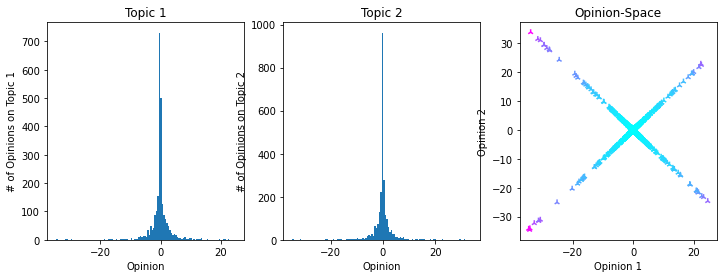

In [21]:
data = np.loadtxt(r'D:\Daten mit Änderungen\Physik\Bachelorarbeit\Generated_Data\Original\Test.csv', delimiter=',')

def Plot_Opinion_Distribution_2d(data1, data2, data_act):
    op1_list = data1
    op2_list = data2

    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].set_title("Topic 1")
    ax[0].set_xlabel("Opinion")
    ax[0].set_ylabel("# of Opinions on Topic 1")
    ax[0].hist(op1_list, bins=120)
    ax[1].set_title("Topic 2")
    ax[1].set_xlabel("Opinion")
    ax[1].set_ylabel("# of Opinions on Topic 2")
    ax[1].hist(op2_list, bins=120)
    ax[2].set_title("Opinion-Space")
    ax[2].set_xlabel("Opinion 1")
    ax[2].set_ylabel("Opinion 2")
    ax[2].scatter(op1_list, op2_list, c=data_act, cmap='cool', marker = '2')
    plt.show()

Plot_Opinion_Distribution_2d(data[1], data[2], data[0])
Plot_Opinion_Distribution_2d(data[len(data)-2], data[len(data)-1], data[0])